# <div align="center">Entanglement Entropy of the TFIM in one Dimension</div>

An interesting property of the one dimensional transverse Ising Model is that in the quantum mechanical model, the wave function can constitute of entangled states. 
The entanglement entropy measures the degree of quantum entanglement between two given subsystems, which therefor form a bipartite quantum system. It is given by the von Neumann entropy of the reduced density matrix of any of the two subsystems $A$ and $B$
\begin{align}
\mathscr{S}(\rho_A) &= -\text{Tr}(\rho_A \ln (\rho_A)) = \mathscr{S}(\rho_B) \\
\text{where} \quad \rho_A &= \text{Tr}_B(| \Psi \rangle \langle \Psi |), \quad \rho_B = \text{Tr}_A(| \Psi \rangle \langle \Psi |)
\end{align}
where $|\Psi\rangle $ describes the composite system.

For an MPS with open boundary conditions, one first has to choose two subsystems $A$ and $B$ of interest, which are obtained by simply cutting the MPS in two parts at a chosen chain length $L$. Hence, one obtains two subsystems $A$ of length $L$ and $B$ of length $N-L$, where $N$ depicts the number of particles, i.e. the length of the MPS.

It an be then shown, that in order to calculate the entanglement entropy via the von-Neumann entropy of those two subsystems, one can simply left-gauge all MPS elements to the left of the intersection point $k$ at $L$ (the so-called gauge center) and right-gauge all MPS elements to the right of $k$. As a result, the elements to the left of $k$ are left-orthonomal and the elements to the right of $k$ are right orthogonal. The entanglement entropy $\mathscr{S}$ can then be obtained from the singular values $S_{\beta \beta}$ of the MPS element at the intersection point $k$, which can be obtained from a SVD, as follows
\begin{align}
\mathscr{S} = \sum_{\beta} S_{\beta, \beta}^2 \ln (S_{\beta, \beta}^2)
\end{align}

In [2]:
# import self-made MPS/MPO functions
from MPSfunc_lib import *

## Part 1: Entanglement Entropy Ground State per Iteration Step

In [4]:
#modified TEBD which includes calculation of entanglement entropy 
#in every step with L = N/2
def getGroundstate(conf, time_stamp):
    #random normalized MPS to start iteration
    start = genMPS(gen_bonddims(conf.N, conf.bdim_start))
    right_normalizeMPS(start)

    #hamiltonian
    hamiltonian = genH(len(start), conf.J, conf.beta)

    #generate 2-particle gates U1, U2, U3 for start step size dt0
    U1, U2, U3 = gen2particleGatesU(0, conf.J, conf.beta, conf.dt0)

    #energy expectation value per step
    E = []
    energy = getEnergyExpVal(start, hamiltonian)
    E.append(energy)
    
    #relative error energy per step
    rel_err = 1
    #exponential error
    exp_err = conf.eps_tol

    #slope energy per time
    slope = 1

    #apply 2-particle time evolution gates sequentially
    tmp = start;

    #extrapolation exact ground state energy E0 from trotter error using E1=E(dt1) and E2=E(dt2)
    E1 = energy
    dt1 = conf.dt0 + 0.1

    #Dumping all the output into file.
    #now = datetime.now().strftime("%y%m%d%H%M%S")
    dump_stream = open(f"./out/run_groundstate_N{conf.N}_J{conf.J}_beta{conf.beta}_{time_stamp}.txt", 'w')
    dump_stream.write(f"{'[conf]':12s} {'N':>10s} {conf.N:>15d}\n")
    dump_stream.write(f"{'[conf]':12s} {'J':>10s}  {conf.J:>15.3f}\n")
    dump_stream.write(f"{'[conf]':12s} {'beta':>10s} {conf.beta:>15.3f}\n")
    dump_stream.write(f"{'[conf]':12s} {'dt0':>10s} {conf.dt0:>15.3e}\n")
    dump_stream.write(f"{'[conf]':12s} {'eps_trunc':>10s} {conf.eps_trunc:>15.3e}\n")
    dump_stream.write(f"{'[conf]':12s} {'eps_dt':>10s} {conf.eps_dt:>15.3e}\n")
    dump_stream.write(f"{'[conf]':12s} {'eps_tol':>10s} {conf.eps_tol:>15.3e}\n")
    dump_stream.write(f"{'[conf]':12s} {'Dmax':>10s} {conf.Dmax:>15d}\n")
    dump_stream.write(f"{'[conf]':12s} {'dt_red':>10s} {conf.dt_red:>15.3f}\n")
    dump_stream.write(f"{'[conf]':12s} {'phys_gap':>10s} {conf.phys_gap:>15.3e}\n")

    dump_stream.write(f"{'[info]':12s} {'i':>5s} {'MBD':>8s} {'dt':>17s} {'E':>17s} {'rel_err':>17s} {'exp_err':>17s} {'slope':>17s} {'ent_entropy':>17s}\n")
    
    #set step size for start
    dt = conf.dt0

    i = 1
    while(dt > conf.eps_dt):
        #apply 2-particle gates U1, U2, U3
        for j in range(len(tmp)-1):
            tmp = evolve2state(U2, dt, tmp, j)
        tmp = evolve2state(U3, dt, tmp, len(tmp)-2)
        for j in range(len(tmp)-1):
            tmp = evolve2state(U1, dt, tmp, j)
        for j in range(len(tmp)-1):
            tmp = evolve2state(U2, dt, tmp, j)
        tmp = evolve2state(U3, dt, tmp, len(tmp)-2)

        #normalization & truncation
        mean_bonddim = truncateMPS(tmp, conf.eps_trunc, conf.Dmax)

        #energy expectation value current state
        prev_energy = energy
        energy      = getEnergyExpVal(tmp, hamiltonian)
        E.append(energy)
        
        entropy = calc_entanglement_entropy(int(conf.N/2), tmp)

        #calculate slope energy vs. t
        slope = (energy-prev_energy)/dt

        if (i != 1):
            #calculate relative error energy per step
            rel_err = (energy - prev_energy)/prev_energy

            #calculate exponential error
            exp_err = np.abs(rel_err)/np.abs(conf.phys_gap)/pow(dt, 4)

        #reduce time step if exp_err < eps_tol by dt_red
        if (exp_err < conf.eps_tol):
            dt_prev = dt
            dt = dt * conf.dt_red
            U1, U2, U3 = gen2particleGatesU(0, conf.J, conf.beta, dt)

            #extrapolation exact ground state energy E0 from trotter error by E1=E(dt1) and E2=E(dt2)
            d1 = pow(dt1, 4)
            d2 = pow(dt_prev, 4)
            E0 = d1*d2/(d2-d1)*(E1/d1 - energy/d2)
            E1 = energy
            dt1 = dt_prev

            #print(f"(i={i:3d}) reduced time step from {dt_prev:10.6f} to {dt:10.6f}")
            dump_stream.write(f"{'[update_dt]':12s} (i={i:3d}) Reduced time step from {dt_prev:10.6f} to {dt:10.6f}\n")
            dump_stream.write(f"{'[update_E0]':12s} (i={i:3d}) Extrapolated energy ground state E0: {E0:10.6f}\n")

        #print("(i=%3d) MBD=%8.3f, E=%15.10f, rel_err=%12.6e, exp_err=%12.6e" %(i, mean_bonddim, energy, rel_err, exp_err))
        if(i==1):
            k = 0
            start_ent = calc_entanglement_entropy(int(conf.N/2), start)
            dump_stream.write(f"{'[itstep]':12s} {k:5d} {mean_bonddim:8.3f} {dt:17.3e} {energy:17.10f} {rel_err:17.6e} {exp_err:17.6e} {slope:17.6e} {start_ent:17.10f}\n")

        dump_stream.write(f"{'[itstep]':12s} {i:5d} {mean_bonddim:8.3f} {dt:17.3e} {energy:17.10f} {rel_err:17.6e} {exp_err:17.6e} {slope:17.6e} {entropy:17.10f}\n")

        #increase iteration step
        i = i + 1

    dump_stream.write(f"\n{'[info]':12s} {'steps':>5s} {'dt':>8s} {'E0':>17s} {'E':>17s}\n")
    dump_stream.write(f"{'[output]':12s} {i:5d} {dt:8.3f} {E0:17.10f} {energy:17.10f}\n")

    print(f"Iteration steps: {i}")
    print(f"Energy ground state: {energy:15.10f}")
    print(f"Extrapolated ground state energy: {E0: f}\n")
    #start_ent = calc_entanglement_entropy(int(conf.N/2), start)
    print(f"Entanglement Entropy Start: {start_ent: f}\n")

    dump_stream.close()
    return E0, energy, tmp;

In [5]:
#calculate groundstate for N particles
N = 50
J = 0.1
beta = 1

dt0 = 0.4
eps_dt = 0.09

dt_red = 0.8
eps_tol = 0.01
phys_gap = 0.01

eps_trunc = 1e-4
Dmax = 10
bdim_start = 3

conf = ImagiTime_config(N=N, J=J, beta=beta, dt0=dt0, eps_trunc=eps_trunc, 
                        Dmax=Dmax, eps_dt=eps_dt, dt_red=dt_red, 
                        eps_tol=eps_tol, phys_gap=phys_gap, bdim_start=bdim_start)
now = datetime.now().strftime("%y%m%d%H%M%S")
E0, E, groundstate = getGroundstate(conf, now)

Iteration steps: 35
Energy ground state:  -50.1225659167
Extrapolated ground state energy: -50.122573

Entanglement Entropy Start:  0.705224



In [6]:
#data files
data_file = f"./out/run_groundstate_N{N}_J{J}_beta{beta}_{now}.txt"
#file in which the selected results can be stored in the folder data
store_file = f"./out/data/energy_vs_t_N{N}_J{J}_beta{beta}.txt"

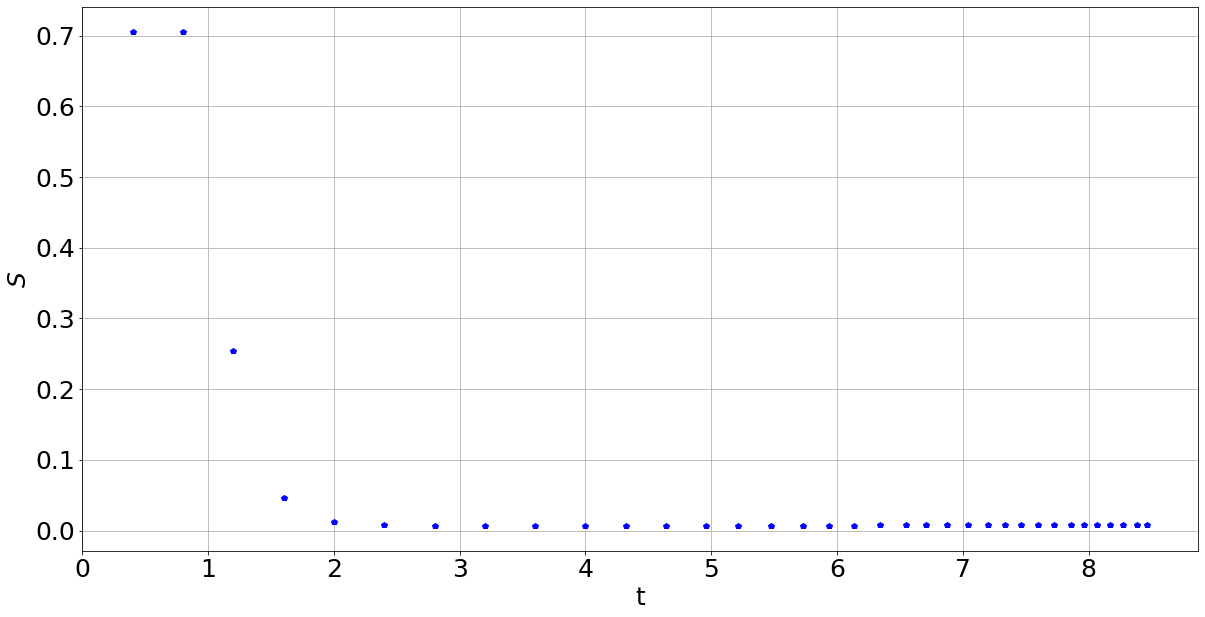

In [7]:
#Plot entanglement entropy S vs. (steps) t
fig, ax = mp_canvas(10, 2/1)
ax.set_ylabel(r'$S$')

# extract correct data from data file
x, y = extract_params_from_file(data_file, store_file, "[itstep]", [3,8])

#plot data depending on t
ax.set_xlabel("t")
ax.plot(np.cumsum(x), np.abs(y), 'p', label=r'$S$', color='blue', linewidth=2)

#plot data depending on steps
# ax.set_xlabel("steps")
# ax.plot(np.arange(0, len(y)), np.abs(y), 'p', label=r'$S$', color='red', linewidth=2)

#mp_savePDF("./results/entropy_per_step", fig)

## Part 2: Decay of the Singular Values

We examine dependence entanglement entropy of the length of the smaller bipartite $l$ for different couplings $J/\beta$ around the QCP, where the intersection point is given by $k=N/2$. Also, we look at the corresponding singular values, used to compute the entanglement entropy $\mathscr{S}$ for a maximal bond dimension of $D_{\text{max}}=10$. In order to yield a good approximation to the ground state, we expect the singular values to decay significantely.
The analysis was performed using the **Python**-Script _MPS_Program_sing_vals.py_ for different $N$ and $J/\beta$.

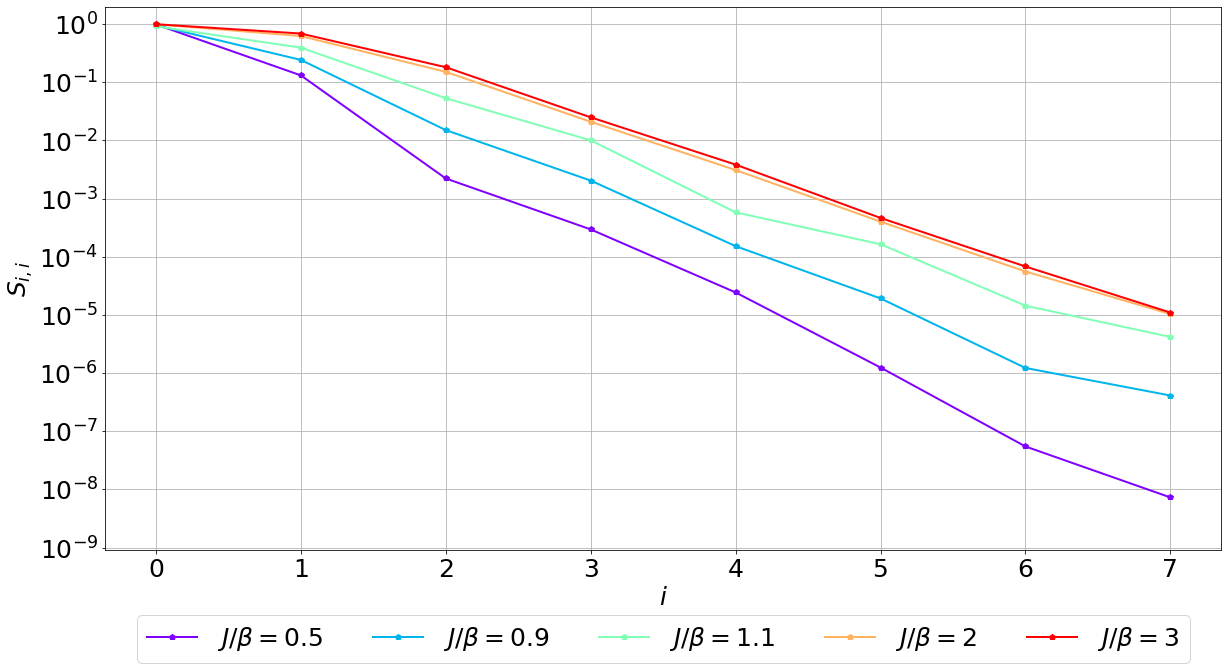

In [4]:
#'''Singular values for N = 10'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$S_{i,i}$")
plt.yscale('log')
plt.ylim(0.0000000009, 2)
plt.xticks(np.arange(0, 11, step=1))  # Set label locations.
plt.yticks([0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]) 

J = [0.5, 0.9, 1.1, 2, 3]
xvec = []
yvec = []

for i in range(len(J)):
    fn = "../Data/entropy/singular_values_N=10_J=" + str(J[i]) + "_D=10.txt"
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i], 'p-', label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.23], loc='lower center', ncol=5)

# mp_savePDF("./results/sing_vals_corr_D=10_N=10", fig)

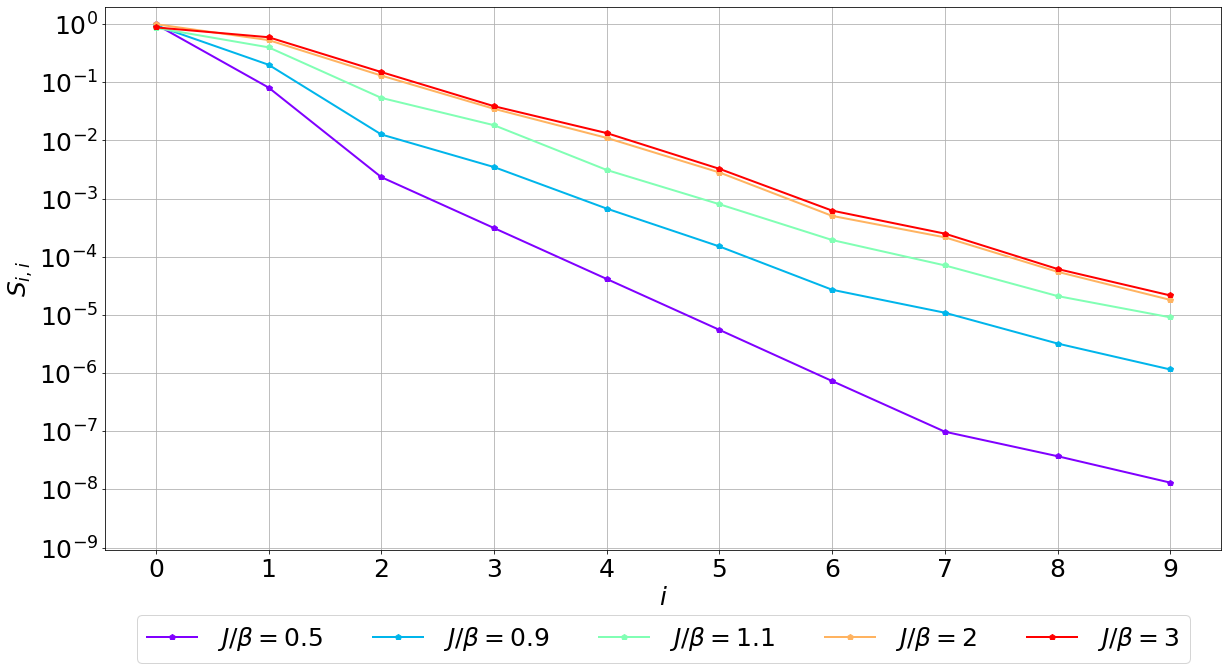

In [5]:
#'''Singular values for N = 20'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$S_{i,i}$")
plt.yscale('log')
plt.ylim(0.0000000009, 2)
plt.xticks(np.arange(0, 11, step=1))  # Set label locations.
plt.yticks([0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]) 

J = [0.5, 0.9, 1.1, 2, 3]
xvec = []
yvec = []

for i in range(len(J)):
    fn = "../Data/entropy/singular_values_N=20_J=" + str(J[i]) + "_D=10.txt"
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i], 'p-', label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.23], loc='lower center', ncol=5)

# mp_savePDF("./results/sing_vals_corr_D=10_N=20", fig)

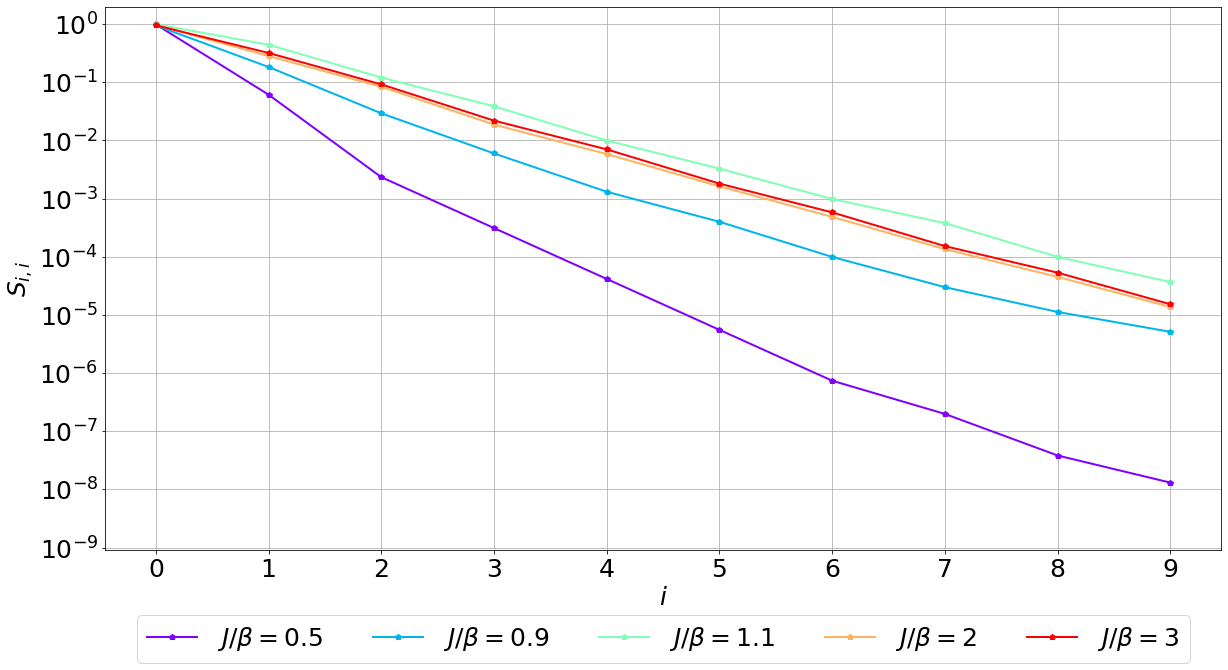

In [6]:
#'''Singular values for N = 50'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$S_{i,i}$")
plt.yscale('log')
plt.ylim(0.0000000009, 2)
plt.xticks(np.arange(0, 11, step=1))  # Set label locations.
plt.yticks([0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]) 

J = [0.5, 0.9, 1.1, 2, 3]
xvec = []
yvec = []

for i in range(len(J)):
    fn = "../Data/entropy/singular_values_N=50_J=" + str(J[i]) + "_D=10.txt"
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i], 'p-', label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.23], loc='lower center', ncol=5)

# mp_savePDF("./results/sing_vals_corr_D=10_N=50", fig)

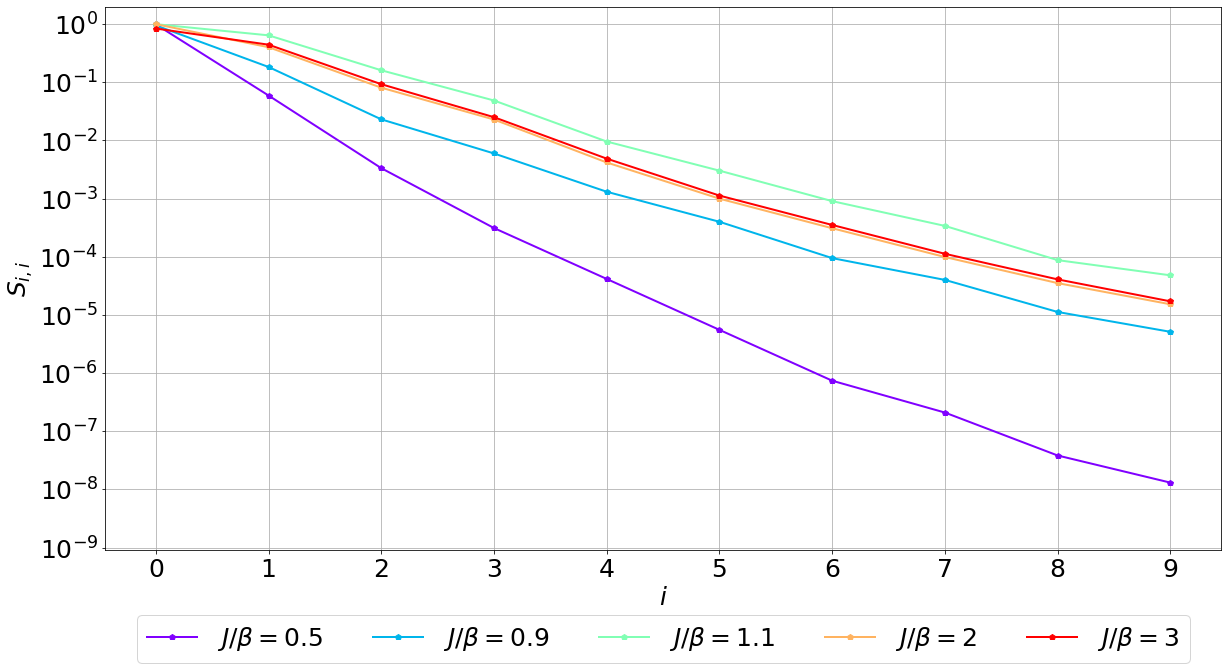

In [7]:
#'''Singular values for N = 100'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$S_{i,i}$")
plt.yscale('log')
plt.ylim(0.0000000009, 2)
plt.xticks(np.arange(0, 11, step=1))  # Set label locations.
plt.yticks([0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]) 

J = [0.5, 0.9, 1.1, 2, 3]
xvec = []
yvec = []

for i in range(len(J)):
    fn = "../Data/entropy/singular_values_N=100_J=" + str(J[i]) + "_D=10.txt"
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i], 'p-', label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.23], loc='lower center', ncol=5)

# mp_savePDF("./results/sing_vals_corr_D=10_N=100", fig)

## Part 3: Entanglement Entropy Ground State vs $l$
For each computed results the entropy is multiplied with an additional factor of $\ln(2)$, due to the definition used. The analysis was performed using the **Python**-Script _MPS_Program_S_vs_l.py_.

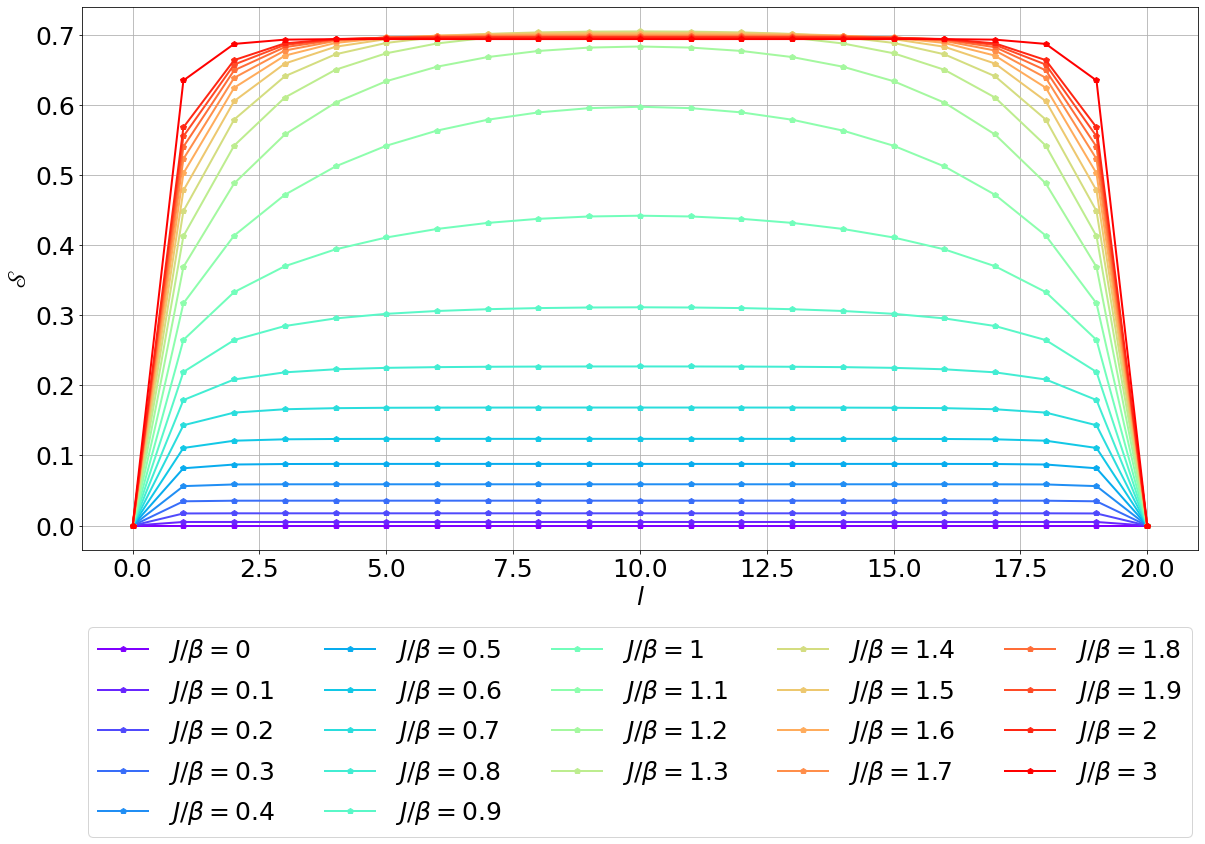

In [8]:
#'''Entropy depending on subsystem length l for N = 20'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

J = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 
     1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3]
xvec = []
yvec = []
h1 = np.array([0]) 
h2 = np.array([20]) 

for i in range(len(J)):
    fn = "../Data/entropy/entrropy_vs_l_N=20_Jbeta=" + str(J[i]) + ".txt"
    x, y = mp_loadtxtfile(fn)
    new_x = np.append(h1, x+1)
    new_y = np.append(h1, y)
    new_x = np.append(new_x, h2)
    new_y = np.append(new_y, h1)
    xvec.append(new_x)
    yvec.append(new_y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i]*np.log(2), 'p-', 
            label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.55], loc='lower center', ncol=5)

#mp_savePDF("./results/entropy_N=20_all_wl", fig)

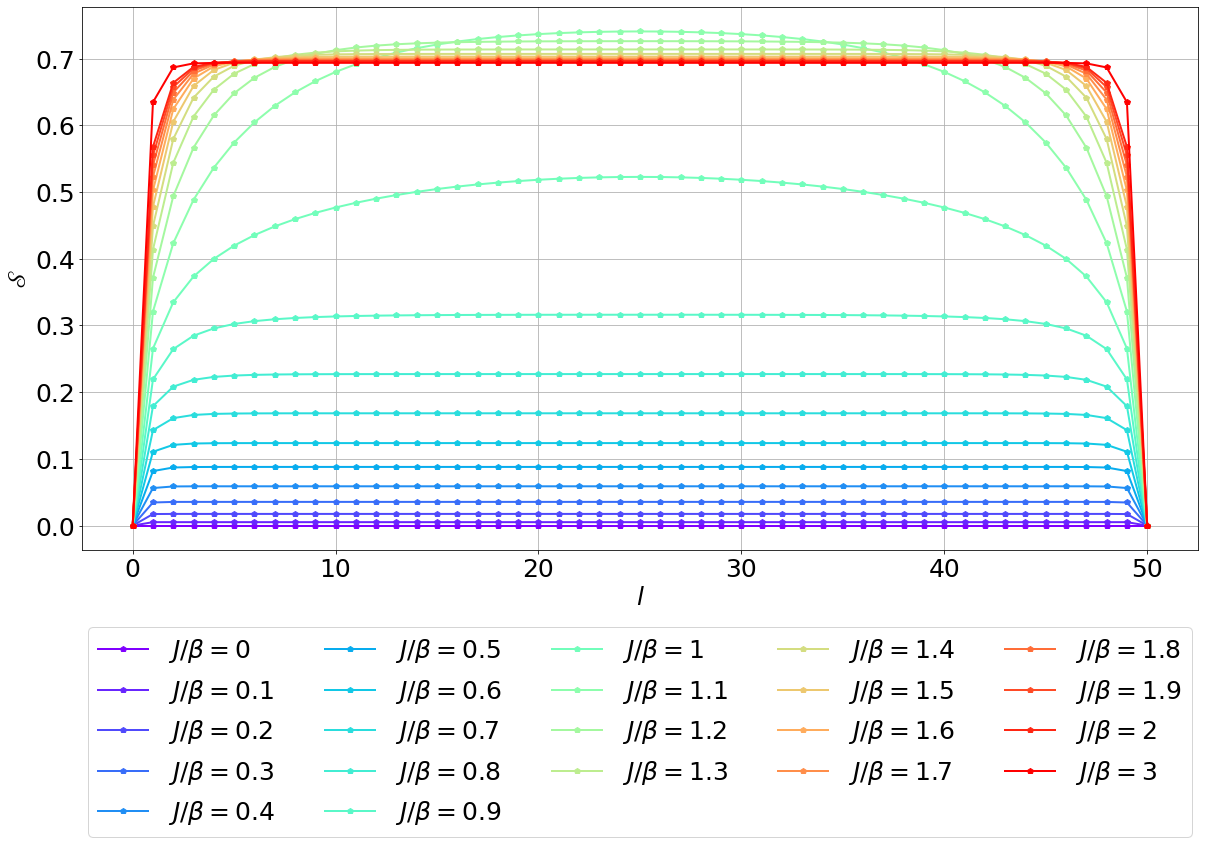

In [9]:
#'''Entropy depending on subsystem length l for N = 50'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

J = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 
     1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3]
xvec = []
yvec = []
h1 = np.array([0]) 
h2 = np.array([50]) 

for i in range(len(J)):
    fn = "../Data/entropy/entrropy_vs_l_N=50_Jbeta=" + str(J[i]) + ".txt"
    x, y = mp_loadtxtfile(fn)
    new_x = np.append(h1, x+1)
    new_y = np.append(h1, y)
    new_x = np.append(new_x, h2)
    new_y = np.append(new_y, h1)
    xvec.append(new_x)
    yvec.append(new_y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i]*np.log(2), 'p-', 
            label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.55], loc='lower center', ncol=5)

#mp_savePDF("./results/entropy_N=50_all_wl", fig)

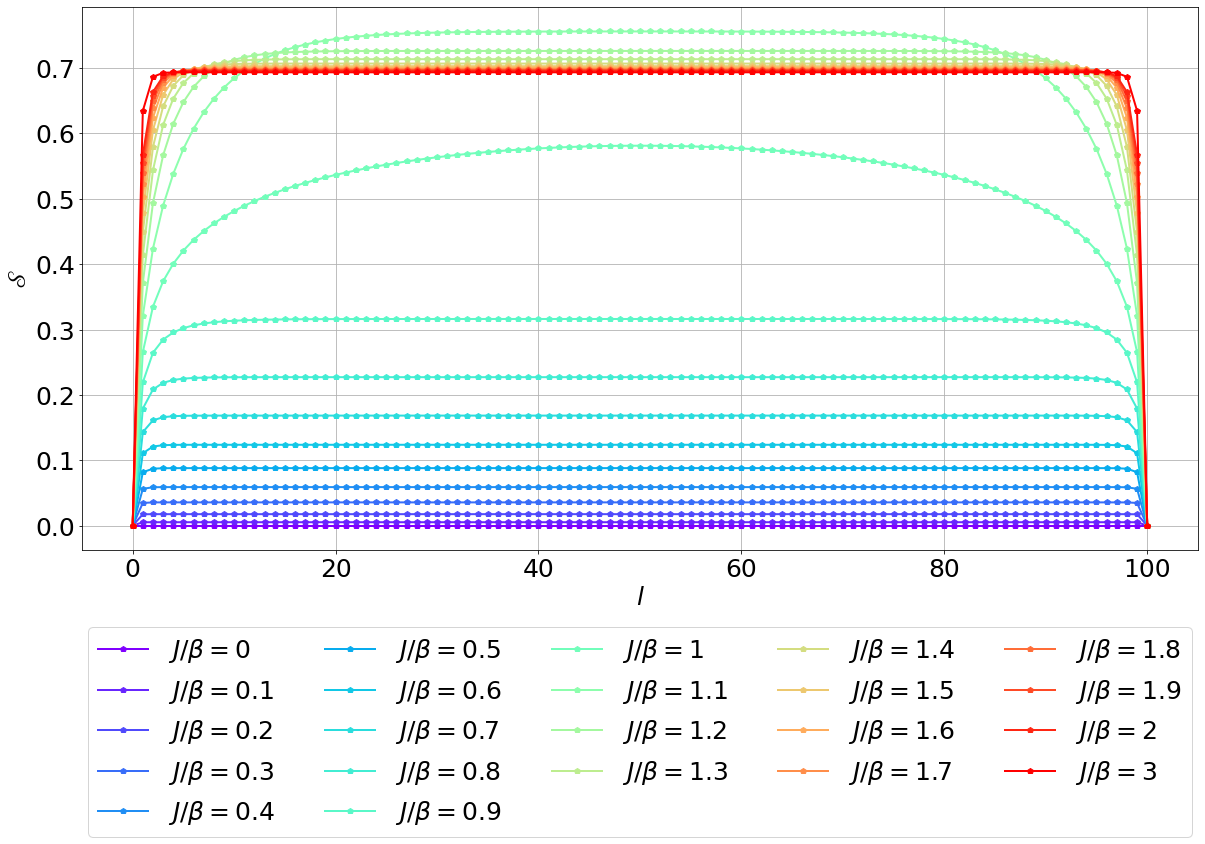

In [10]:
#'''Entropy depending on subsystem length l for N = 100'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

J = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 
     1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3]
xvec = []
yvec = []
h1 = np.array([0]) 
h2 = np.array([100]) 

for i in range(len(J)):
    fn = "../Data/entropy/entrropy_vs_l_N=100_Jbeta=" + str(J[i]) + ".txt"
    x, y = mp_loadtxtfile(fn)
    new_x = np.append(h1, x+1)
    new_y = np.append(h1, y)
    new_x = np.append(new_x, h2)
    new_y = np.append(new_y, h1)
    xvec.append(new_x)
    yvec.append(new_y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
for i in range(len(J)):
    col=next(color)
    ax.plot(xvec[i], yvec[i]*np.log(2), 'p-', 
            label=r"$J/\beta=$"+str(J[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.55], loc='lower center', ncol=5)

#mp_savePDF("./results/entropy_N=100_all_wl", fig)

## Part 4: Entanglement Entropy Ground State vs. $J/\beta$
Taking the previous groundstate as new starting state for ground state iteration.

In [18]:
#ground state calculation with input state start
def getGroundstate(conf, date_stamp, start):
    #hamiltonian
    hamiltonian = genH(len(start), conf.J, conf.beta)

    #generate 2-particle gates U1, U2, U3 for start step size dt0
    U1, U2, U3 = gen2particleGatesU(0, conf.J, conf.beta, conf.dt0)

    #energy expectation value per step
    E = []
    energy = getEnergyExpVal(start, hamiltonian)
    E.append(energy)

    #relative error energy per step
    rel_err = 1
    #exponential error
    exp_err = conf.eps_tol

    #slope energy per time
    slope = 1

    #apply 2-particle time evolution gates sequentially
    tmp = start;

    #extrapolation exact ground state energy E0 from trotter error using E1=E(dt1) and E2=E(dt2)
    E1 = energy
    dt1 = conf.dt0 + 0.1

    #set step size for start
    dt = conf.dt0

    i = 0
    while(dt > conf.eps_dt):
        #apply 2-particle gates U1, U2, U3
        for j in range(len(tmp)-1):
            tmp = evolve2state(U2, dt, tmp, j)
        tmp = evolve2state(U3, dt, tmp, len(tmp)-2)
        for j in range(len(tmp)-1):
            tmp = evolve2state(U1, dt, tmp, j)
        for j in range(len(tmp)-1):
            tmp = evolve2state(U2, dt, tmp, j)
        tmp = evolve2state(U3, dt, tmp, len(tmp)-2)

        #normalization & truncation
        mean_bonddim = truncateMPS(tmp, conf.eps_trunc, conf.Dmax)
        #mean_bonddim = 1

        #-----------------------------------------------------------------------
        #right-normalize MPS
        right_normalizeMPS(tmp)
        #-----------------------------------------------------------------------

        #energy expectation value current state
        prev_energy = energy
        energy      = getEnergyExpVal(tmp, hamiltonian)
        E.append(energy)

        #calculate slope energy vs. t
        slope = (energy-prev_energy)/dt

        if (i != 0):
            #calculate relative error energy per step
            rel_err = (energy - prev_energy)/prev_energy

            #calculate exponential error
            exp_err = np.abs(rel_err)/np.abs(conf.phys_gap)/pow(dt, 4)

        #reduce time step if exp_err < eps_tol by dt_red
        if (exp_err < conf.eps_tol):
            dt_prev = dt
            dt = dt * conf.dt_red
            U1, U2, U3 = gen2particleGatesU(0, conf.J, conf.beta, dt)

            #extrapolation exact ground state energy E0 from trotter error by E1=E(dt1) and E2=E(dt2)
            d1 = pow(dt1, 4)
            d2 = pow(dt_prev, 4)
            E0 = d1*d2/(d2-d1)*(E1/d1 - energy/d2)
            E1 = energy
            dt1 = dt_prev

        #increase iteration step
        i = i + 1

    return E0, energy, tmp;

In [19]:
'''Parameter'''
N = 4
J = np.linspace(0, 4, 40)
beta = np.full(len(J), 1)

In [21]:
#calculate entanglement entropy depending on J/beta
dt0 = 0.4
eps_dt = 0.03
dt_red = 0.75
eps_tol = 1e-1
phys_gap = 1e-2
eps_trunc = 1e-4
Dmax = 10
bdim_start = 2

x = []
entropy = []
for i in range(len(J)):
    conf = ImagiTime_config(N=N, J=J[i], beta=beta[i], dt0=dt0, eps_trunc=eps_trunc, 
                            Dmax=Dmax, eps_dt=eps_dt, dt_red=dt_red, 
                            eps_tol=eps_tol, phys_gap=phys_gap, bdim_start=bdim_start)
    now = datetime.now().strftime("%y%m%d%H%M%S")    
    if(i < 10):
        #random normalized MPS to start iteration
        start = genMPS(gen_bonddims(conf.N, conf.bdim_start))
        right_normalizeMPS(start)
        E0, E, groundstate = getGroundstate(conf, now, start)
    else:
        E0, E, groundstate = getGroundstate(conf, now, groundstate)

    #calculate entanglement entropy for L=N/2
    entropy.append(calc_entanglement_entropy(int(N/2), groundstate))
    x.append(J[i]/beta[i])

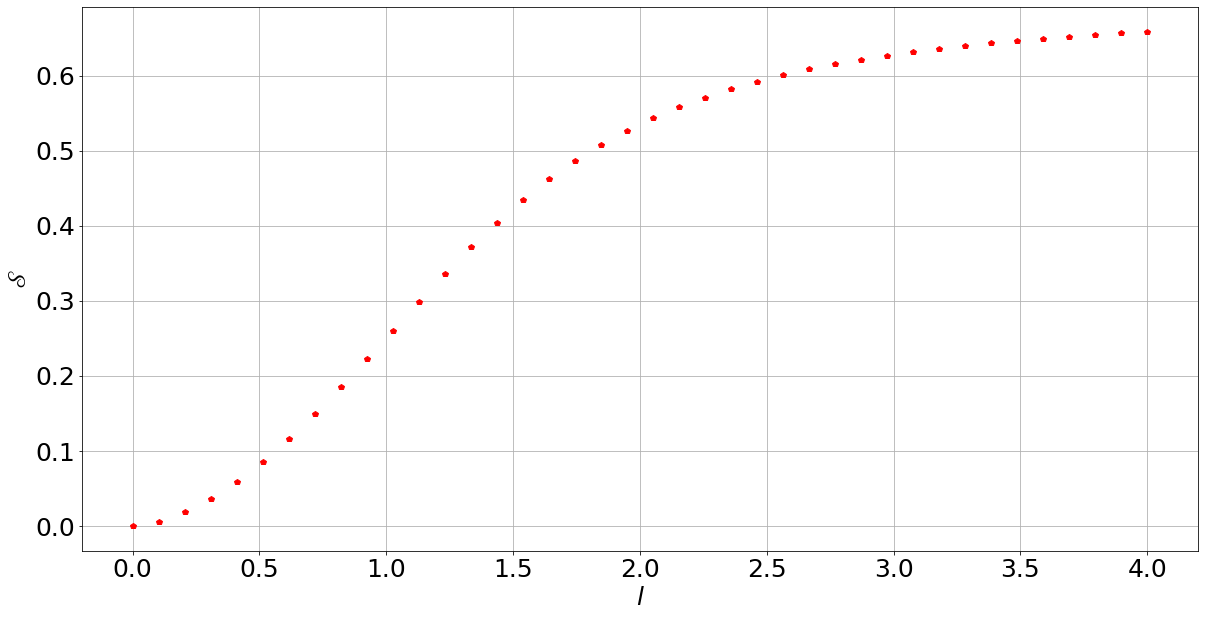

In [22]:
#plot entanglement entropy depending on J/beta
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")
ax.plot(x, np.array(entropy)*np.log(2), 'p', label=r'$N$=' + str(N), 
        color="red", linewidth=2)

### Results from Cluster
The analysis was performed using the **Python**-Script _MPS_Program_S_vs_lambda.py_.

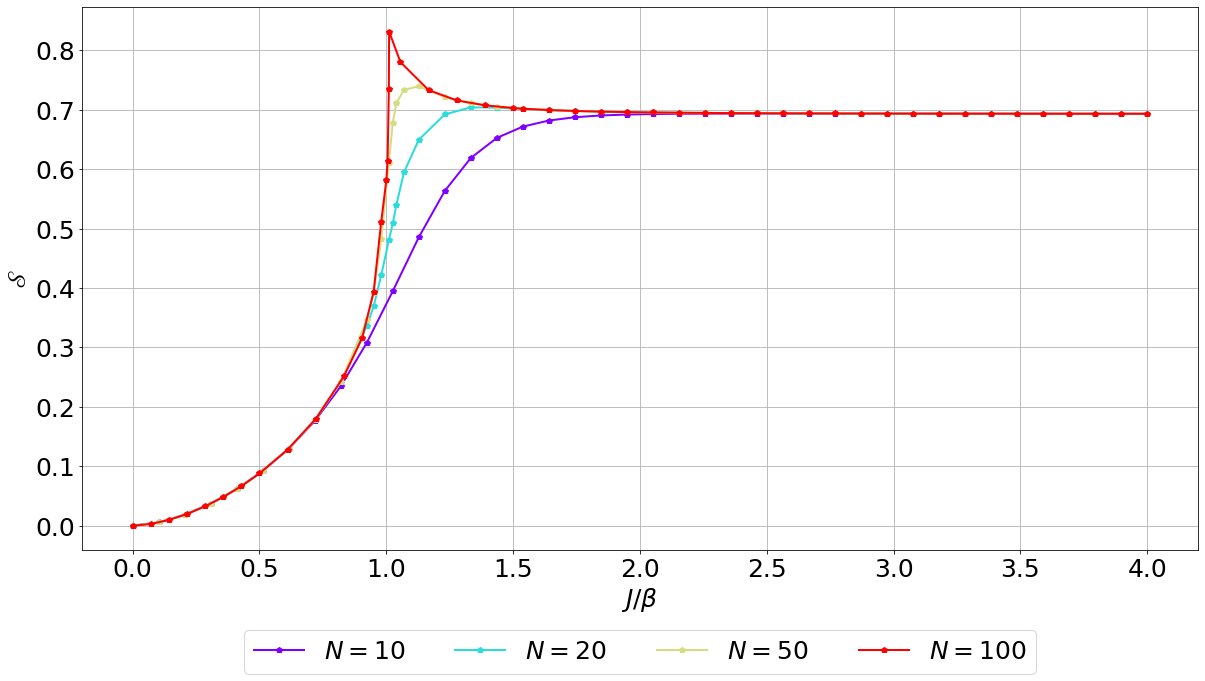

In [11]:
# Entanglement Entropy vs. J/beta with continous computation
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$J/\beta$")
ax.set_ylabel(r"$\mathscr{S}$")
plt.yticks(np.arange(0, 1, step=0.1))  # Set label locations.

Nns = [10, 20, 50, 100]
nplots = len(Nns)
xvec = []
yvec = []

for i in range(nplots):
    fn = "../Data/entropy/entropy_vs_lambda_N=" + str(Nns[i]) +".txt"
    x, y = mp_loadtxtfile(fn) 
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(Nns))))
for i in range(len(xvec)):
    col=next(color)
    ax.plot(xvec[i], (yvec[i])*np.log(2), 'p-', label=r"$N=$"+str(Nns[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/entropy_vs_Jbeta", fig)

If not continous computation, one finds flucutations of the form

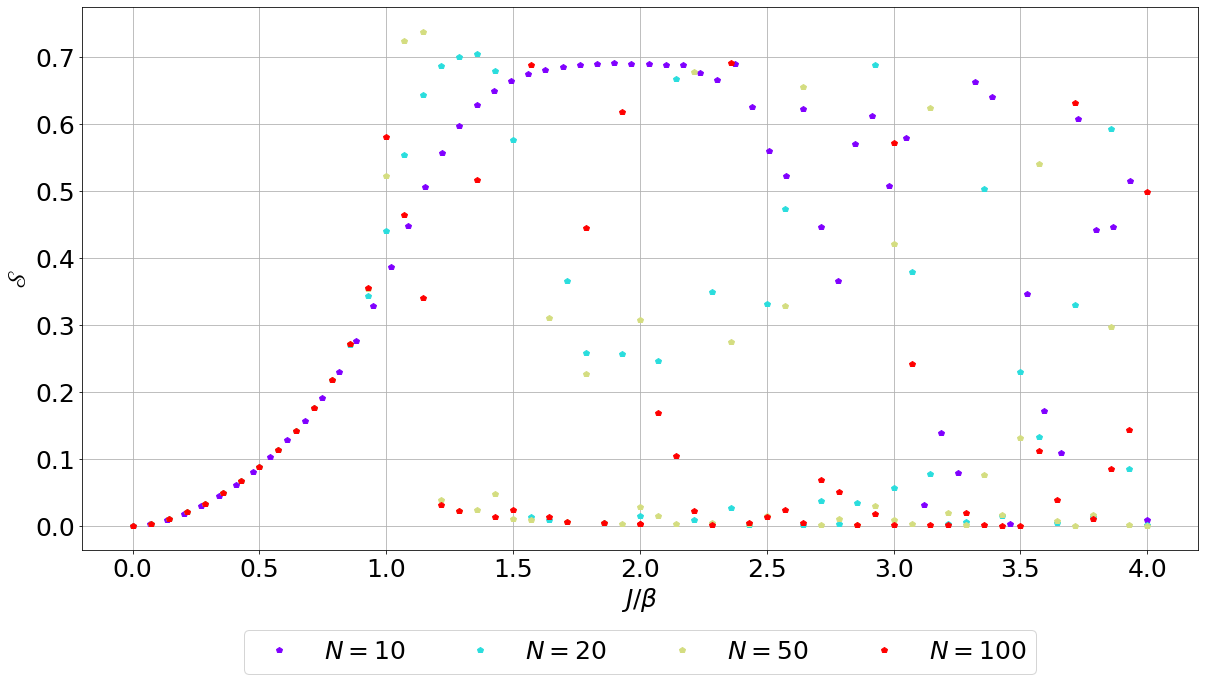

In [12]:
# Entanglement Entropy vs. J/beta with non-continous computation
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$J/\beta$")
ax.set_ylabel(r"$\mathscr{S}$")

Nns = [10, 20, 50, 100]
nplots = len(Nns)
xvec = []
yvec = []

for i in range(nplots):
    fn = "../Data/entropy/entropy_N=" + str(Nns[i]) +".txt"
    x, y = mp_loadtxtfile(fn) 
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(Nns))))
for i in range(len(xvec)):
    col=next(color)
    ax.plot(xvec[i], (yvec[i])*np.log(2), 'p', label=r"$N=$"+str(Nns[i]), 
            color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/entropy_fluc_N=50_100", fig)

One observes fluctuations in the principal singular value $s_0$, of the form

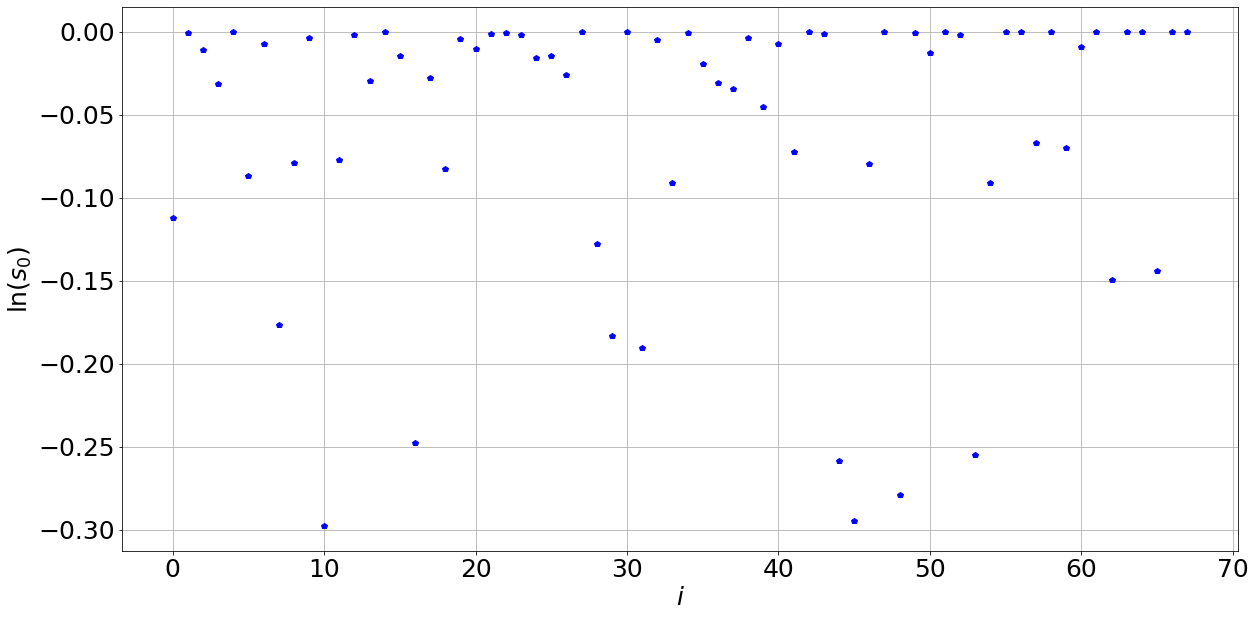

In [13]:
#Plot logarithm of first singular value for several iterations
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\ln(s_0)$")
x,y = mp_loadtxtfile('../Data/entropy/Sfluc_lns_vs_i.txt')
ax.plot(x, y, 'p', label=r"$\ln(s_0)$", color='blue', linewidth=2)

leading for more iterations to histogram of the form

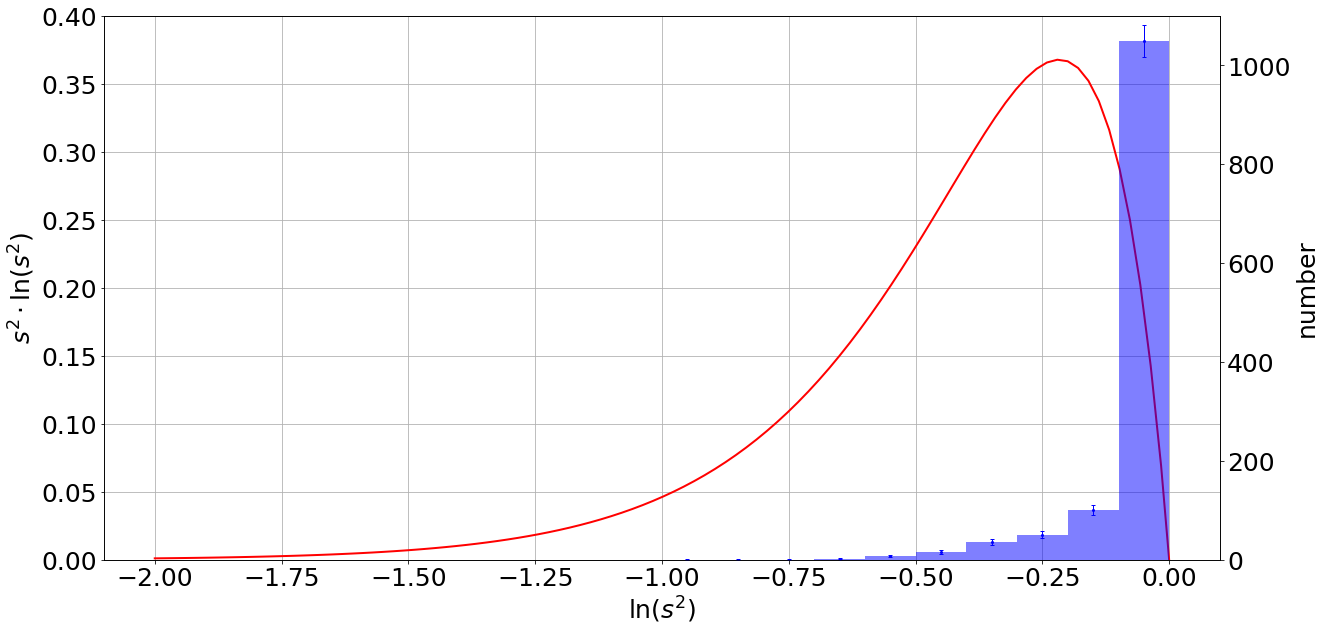

In [14]:
#histogram and entropy dependence of ln(s_0)
fig, ax = mp_canvas(10, 2/1)
ax = plt.gca()
ax2 = ax.twinx()
ax.set_ylabel(r"$s^2\cdot \ln(s^2)$")
ax2.set_ylabel(r"number")
ax.set_xlabel(r"$\ln(s^2)$")
ax.set_ylim(0,0.4)
ax2.set_ylim(0,1100)
ax.set_xlim(-2.1, 0.1)

#histogram
ent = mp_loadtxtfile("../Data/entropy/ln_s_histo.txt")
nbins = 10
a, b = (-1, 0)
n, bins, patches = plt.hist(ent, np.linspace(0,1,nbins+1) * (b-a)+a,
                            facecolor='blue', alpha=0.5)
#plot error bars
bins = bins[0:nbins]+(b-a)/2/nbins
dn = np.sqrt(n)
dn[np.where(n==0)] = 1
mp_errorbar(ax2, bins, n, dn, lab=r'$S$')

#entropy curve
x = np.linspace(-2, np.log(1.025), 100)
s = pow(10,x)
y = -s**2*np.log(s**2)
ax.plot(x, y, '-', label=r"$$", color='red', linewidth=2)

#mp_savePDF("./results/entropy_and_hist", fig)

using the **Python**-Script _MPS_Program_fluct_sing_val.py_ to gain the data.

### Results from DMRG-based Variational Optimization M. Schneider

compare results from TEBD to Manuels results from DMRG based ground state calculation via variational optimization

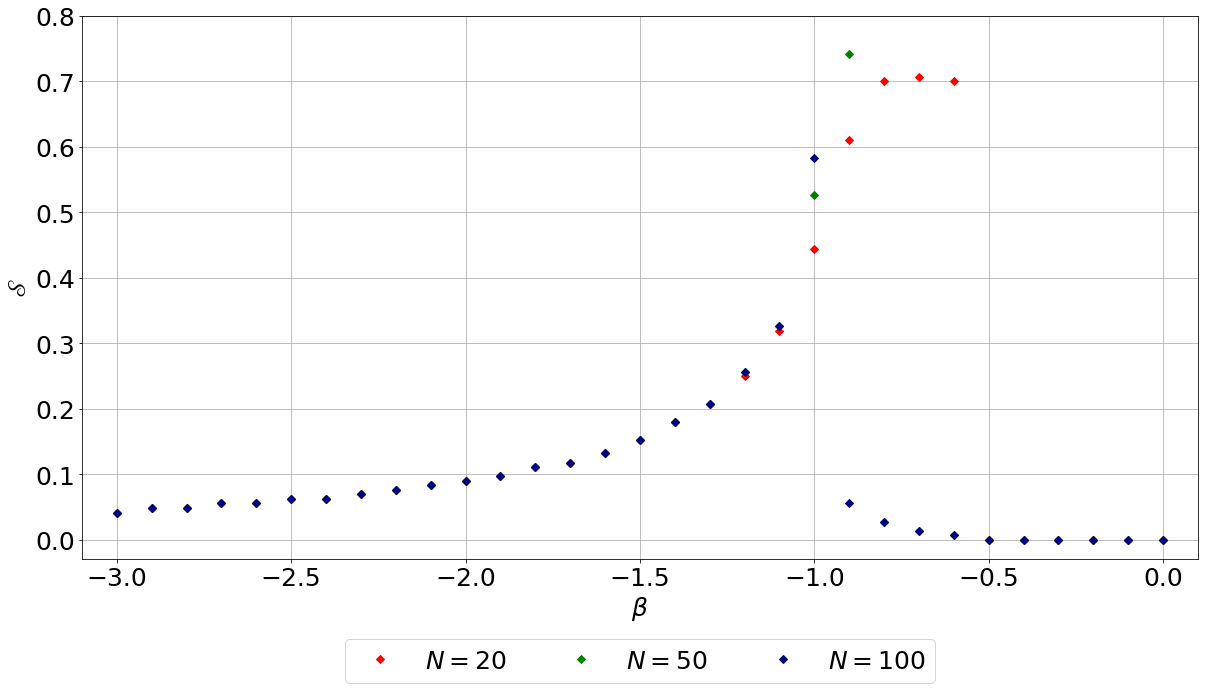

In [15]:
# Entanglement Entropy vs. beta for D_max=10 
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\mathscr{S}$")
plt.xlim(-3.1,0.1)
plt.ylim(-0.03,0.8)

Nns = [20, 50, 100]
nplots = len(Nns)
yvec = []
xvec = []

for i in range(nplots):
    fn = f"../Data/entropy/TransverseIsingModel_HalfCut_D_10_N_{Nns[i]}.txt"
    y = mp_loadtxtfile(fn) 
    yvec.append(y)
    xvec.append(np.arange(0,-3.1,-0.1))
    
ax.plot(xvec[0], (yvec[0])*np.log(2), 'D', label=r"$N=$"+str(Nns[0]), 
        color="red", linewidth=2)
ax.plot(xvec[1], (yvec[1])*np.log(2), 'D', label=r"$N=$"+str(Nns[1]), 
        color="green", linewidth=2)
ax.plot(xvec[2], (yvec[2])*np.log(2), 'D', label=r"$N=$"+str(Nns[2]), 
        color="navy", linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/res_manuel_entropy_vs_beta_D=10_N=100", fig)

## Part 5: Adiabatic Approach Ground State Calculation - Coefficient $c$

In [29]:
#calculate coefficient c from ground state iteration
N = 2
J = np.linspace(0.5, 100, 100)

dt0 = 0.4
eps_dt = 0.09
dt_red = 0.8
eps_tol = 1e-3
phys_gap = 1e-3
eps_trunc = 1e-4
Dmax = 10
bdim_start = 2

c = []

# for i in range(len(J)):
#     conf = ImagiTime_config(N=N, J=J[i], beta=1, dt0=dt0, eps_trunc=eps_trunc, Dmax=Dmax, eps_dt=eps_dt, dt_red=dt_red, eps_tol=eps_tol, phys_gap=phys_gap, bdim_start=bdim_start)
#     date_stamp = datetime.now().strftime("%y%m%d%H%M%S")
#     E0, E, groundstate = getGroundstate(conf, date_stamp)
#     coeff = calc_coeff_state(groundstate)
#     c.append(coeff[0]/coeff[coeff.size()[0]-1])
    
for i in range(len(J)):
    E0, gs = gs_from_exact_diag(N, J[i], 1)
    new_c = gs[gs.size-4]/gs[gs.size-1]
    c.append(np.real(new_c))

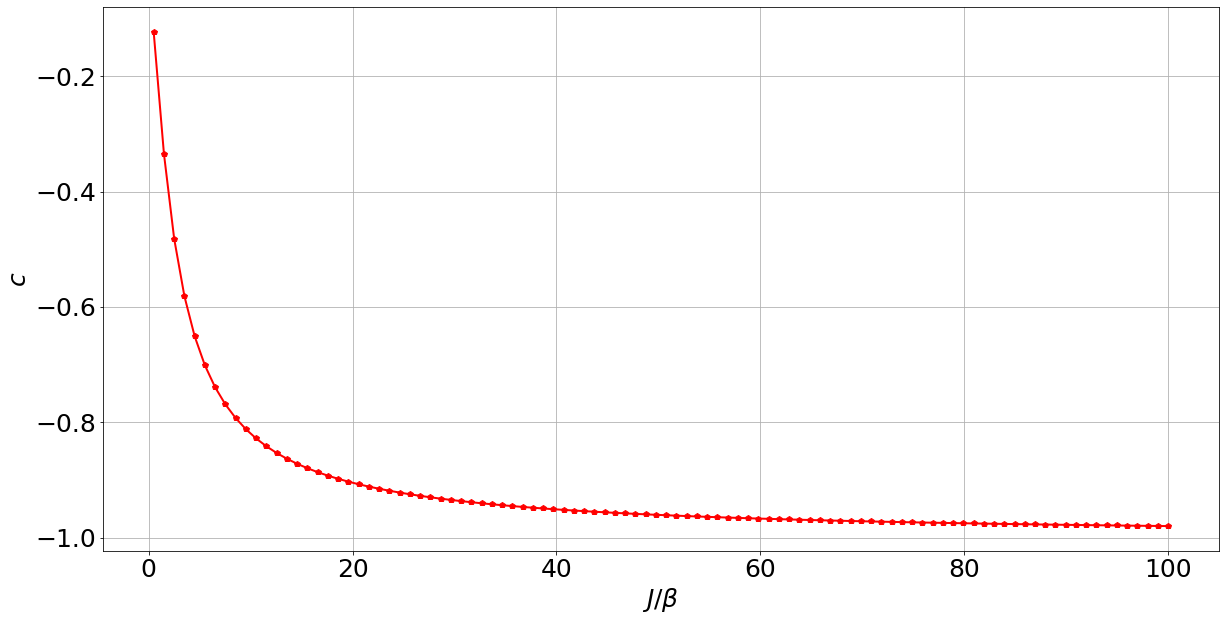

In [30]:
# Coefficient c depending on J/beta
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$J/\beta$")
ax.set_ylabel(r"$c$")
ax.plot(J, c, 'p-', label=r"$c(J/\beta)$", color="red", linewidth=2)

### Results from Cluster
The analysis was performed using the **Python**-Script _MPS_Program_c_vs_lambda.py_.

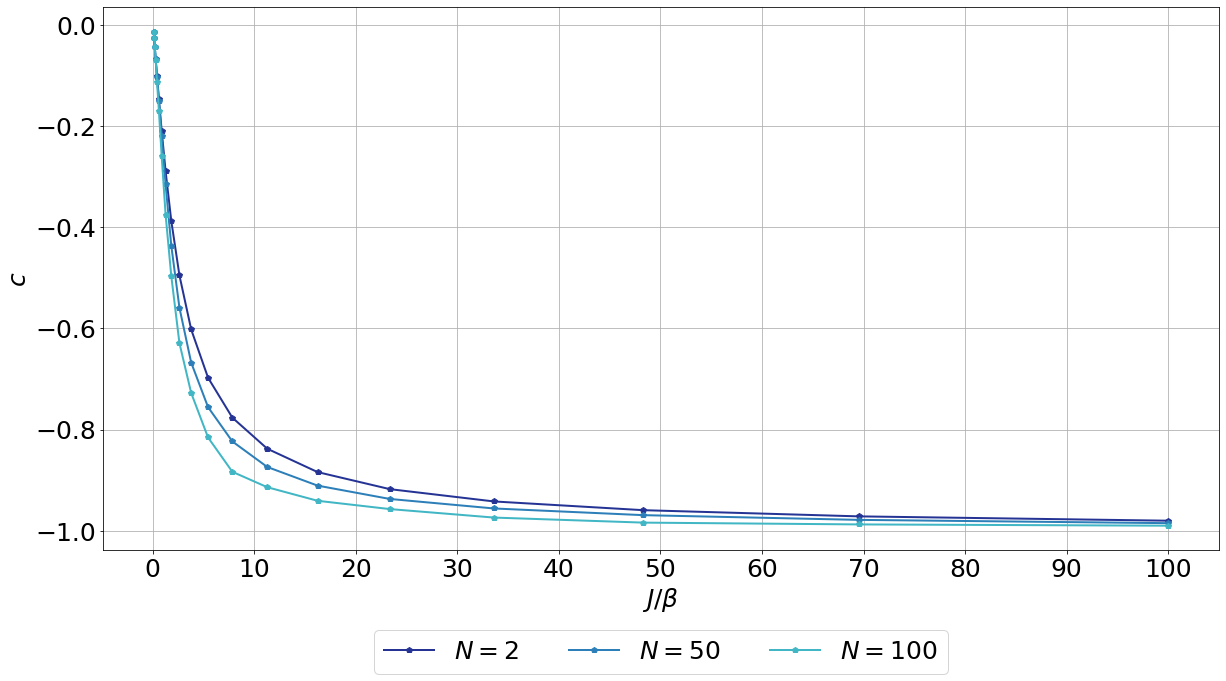

In [16]:
# Results coefficient c vs J/beta
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$J/\beta$")
ax.set_ylabel(r"$c$")
plt.xticks(np.arange(0, 110, step=10))  # Set label locations.

Nns = [2,50,100]
nplots = len(Nns)
xvec = []
yvec = []

for i in range(nplots):
    fn = f"../Data/entropy/coeff_c_vs_Jbeta_N={Nns[i]}.txt"
    x, y = mp_loadtxtfile(fn) 
    xvec.append(x)
    yvec.append(y)

#colors:
#--------------------------------------------------
#color = ["navy", "blue", "dodgerblue"]
#color = ["darkred", "red", "salmon"]
#color = ["darkslategray", "teal", "darkturquoise"]
#color = ["#980043", "#dd1c77", "#df65b0"]
color = ["#253494", "#2c7fb8", "#41b6c4"]
#--------------------------------------------------

for i in range(len(xvec)):
    col = color[i]
    ax.plot(xvec[i], yvec[i], 'p-', label=r"$N=$"+str(Nns[i]), color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/coeff_c_diffN", fig)

## Part 6: Evolution of Entanglement

The analysis was performed using the **Python**-Scripts _MPS_Program_evol_S_vs_l.py_, _MPS_Program_S_vs_t.py_, _MPS_Program_evol_S_states.py_.

### $\mathscr{S}(l)$, starting in a Classical State

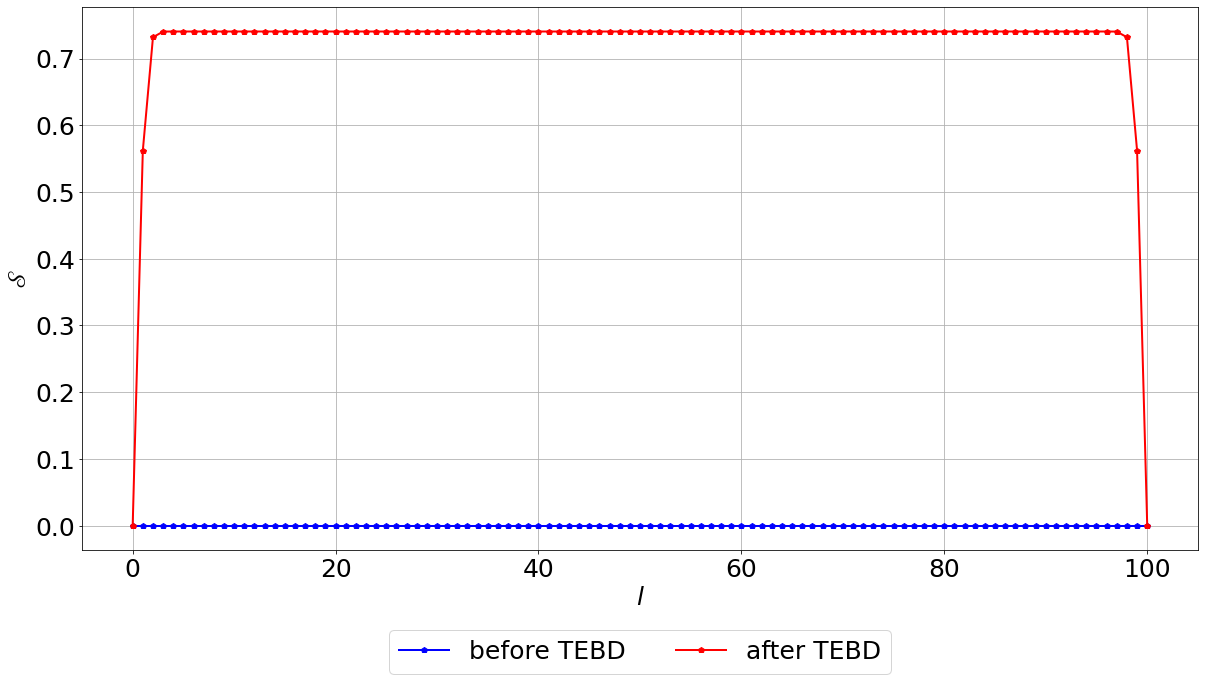

In [17]:
#Starting evolution from classical state N = 100, t=0.5
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

x1,y1 = mp_loadtxtfile('../Data/entropy/S_vs_l_N=100_evol_ent_bef.txt')
x2,y2 = mp_loadtxtfile('../Data/entropy/S_vs_l_N=100_evol_ent_aft.txt')
x1 = np.append(np.array([0]), x1+1)
y1 = np.append(np.array([0]), y1)
x1 = np.append(x1, np.array([100]))
y1 = np.append(y1, np.array([0]))

x2 = np.append(np.array([0]), x2+1)
y2 = np.append(np.array([0]), y2)
x2 = np.append(x2, np.array([100]))
y2 = np.append(y2, np.array([0]))

ax.plot(x1, y1*np.log(2), 'p-', label=r"before TEBD", 
        color='blue', linewidth=2)
ax.plot(x2, y2*np.log(2), 'p-', label=r"after TEBD", 
        color='red', linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/evol_entanglement_from_classical_state_N=100_t=0.5", fig)

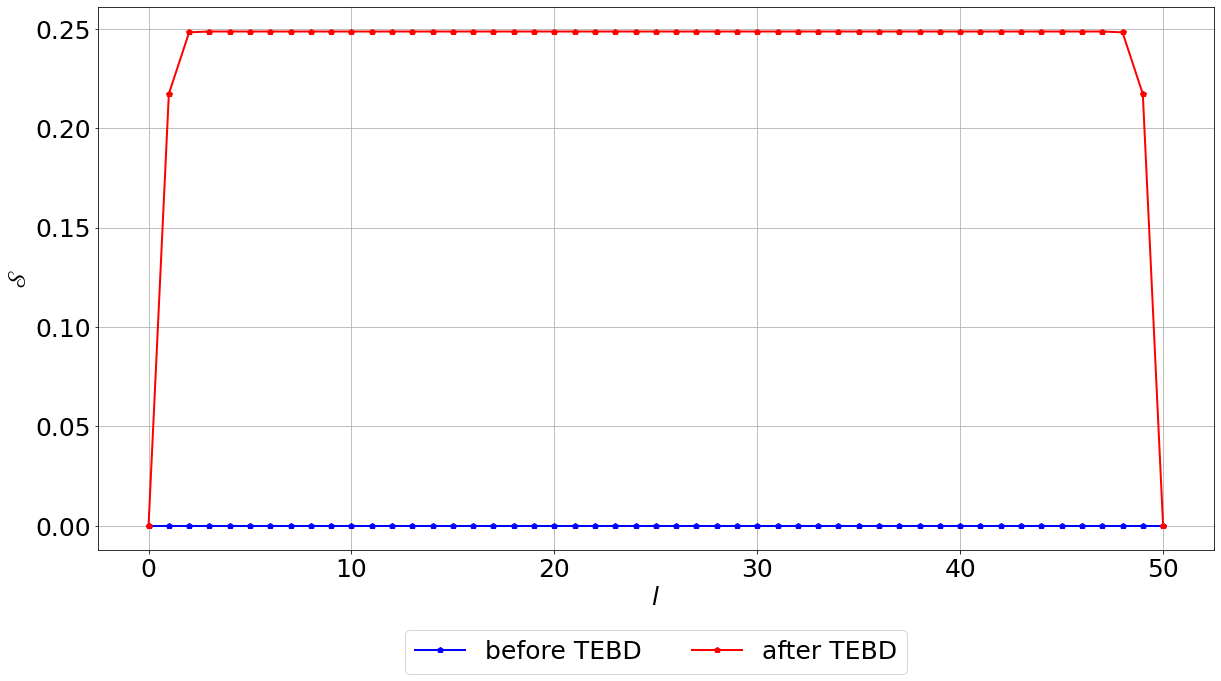

In [18]:
#Starting evolution from classical state N = 50, t=0.5
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

x1,y1 = mp_loadtxtfile('../Data/entropy/S_vs_l_N=50_evol_ent_bef.txt')
x2,y2 = mp_loadtxtfile('../Data/entropy/S_vs_l_N=50_evol_ent_aft.txt')
x1 = np.append(np.array([0]), x1+1)
y1 = np.append(np.array([0]), y1)
x1 = np.append(x1, np.array([50]))
y1 = np.append(y1, np.array([0]))

x2 = np.append(np.array([0]), x2+1)
y2 = np.append(np.array([0]), y2)
x2 = np.append(x2, np.array([50]))
y2 = np.append(y2, np.array([0]))

ax.plot(x1, y1*np.log(2), 'p-', label=r"before TEBD", 
        color='blue', linewidth=2)
ax.plot(x2, y2*np.log(2), 'p-', label=r"after TEBD", 
        color='red', linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.25], loc='lower center', ncol=5)

#mp_savePDF("./results/evol_entanglement_from_classical_state_N=50_t=0.5", fig)

### $\mathscr{S}(t)$

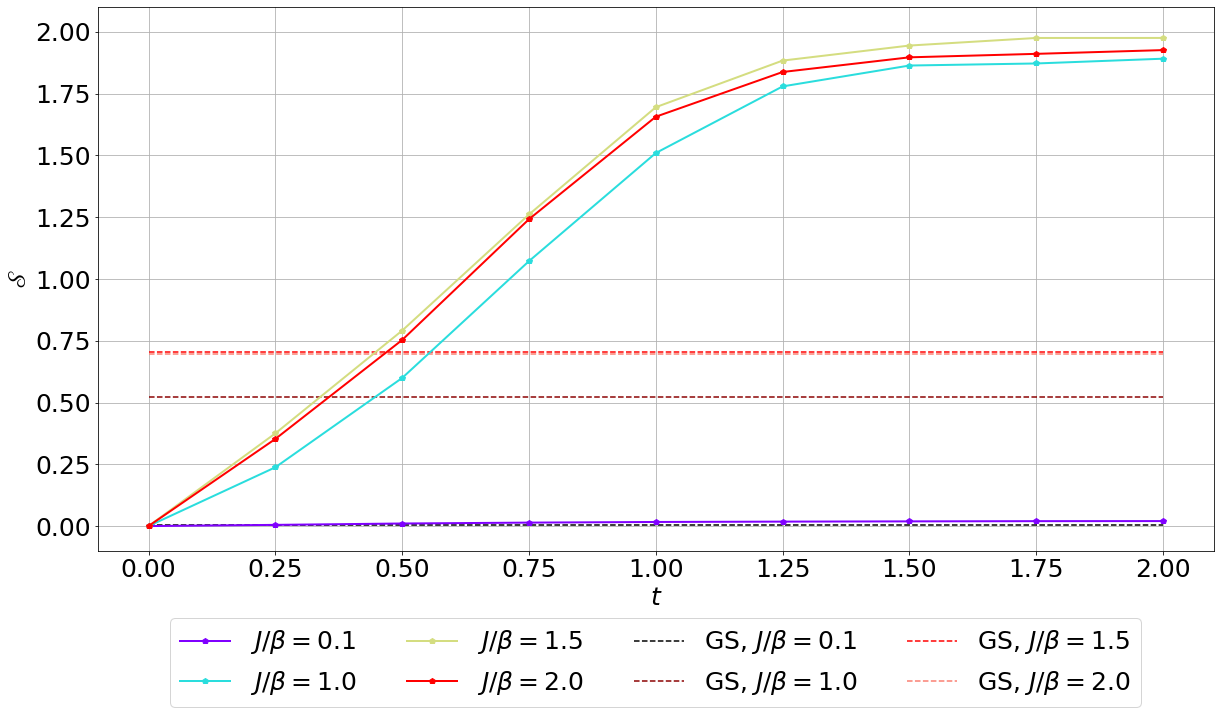

In [19]:
#S(t) for different couplings J/beta N=50
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathscr{S}$")
plt.ylim(-0.1,2.1)

#entropy gs for N=50:
S = [0.007486, 0.754018, 1.014165, 1.003852]

J = [0.1,1.0,1.5,2.0]
xvec = []
yvec = []

for j in range(len(J)):
    fn = f"../Data/entropy/S_of_t_N=50_Jbeta={J[j]}.txt" 
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
color1 = ["black", "darkred", "red", "salmon"]

for j in range(len(J)):
    col=next(color)
    ax.plot(xvec[j], yvec[j]*np.log(2), 'p-', label=r"$J/\beta=$"+str(J[j]), 
                color=col, linewidth=2)
    plt.hlines(S[j]*np.log(2), 0,2, colors=color1[j], linestyles='dashed', 
               label=r"GS, $J/\beta=$"+str(J[j]))
plt.legend(bbox_to_anchor=[0.5, -0.31], loc='lower center', ncol=4)

#mp_savePDF("./results/S_vs_t_diffJ_N50", fig)

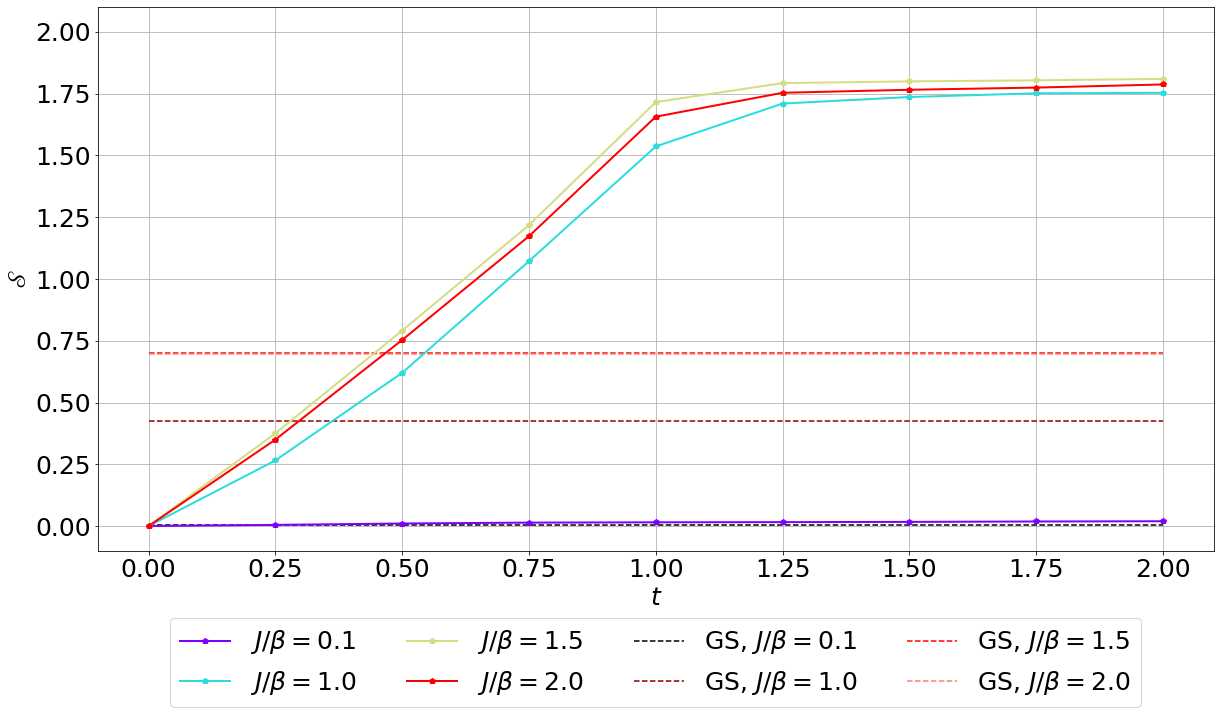

In [20]:
#S(t) for different couplings J/beta N=10
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\mathscr{S}$")
plt.ylim(-0.1,2.1)

#entropy gs for N=10:
S = [0.007486, 0.612393, 1.013065, 1.003842]

J = [0.1,1.0,1.5,2.0]
xvec = []
yvec = []

for j in range(len(J)):
    fn = f"../Data/entropy/S_of_t_N=10_Jbeta={J[j]}.txt" 
    x, y = mp_loadtxtfile(fn)
    xvec.append(x)
    yvec.append(y)

color=iter(cm.rainbow(np.linspace(0,1,len(J))))
color1 = ["black", "darkred", "red", "salmon"]

for j in range(len(J)):
    col=next(color)
    ax.plot(xvec[j], yvec[j]*np.log(2), 'p-', label=r"$J/\beta=$"+str(J[j]), 
                color=col, linewidth=2)
    plt.hlines(S[j]*np.log(2), 0,2, colors=color1[j], linestyles='dashed', 
               label=r"GS, $J/\beta=$"+str(J[j]))
plt.legend(bbox_to_anchor=[0.5, -0.31], loc='lower center', ncol=4)

#mp_savePDF("./results/S_vs_t_diffJ_N10", fig)

### Real-time evolution before, at and after the QCP

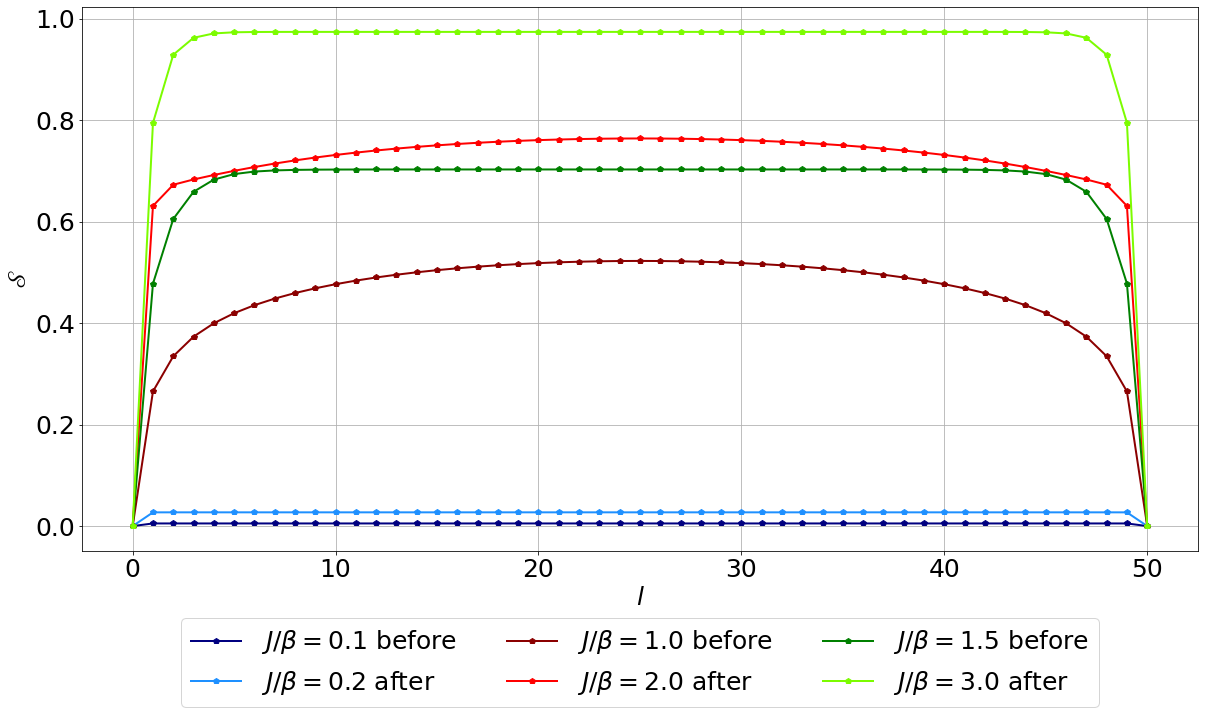

In [21]:
#'''Real-time evolution before, at and after the QCP, N=50, t=0.5s'''
fig, ax = mp_canvas(10, 2/1)
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\mathscr{S}$")

J = np.array([0.1, 1.0, 1.5])
xvec = []
yvec = []
h1 = np.array([0]) 
h2 = np.array([50]) 

for i in range(len(J)):
    for j in range(2):
        fn = f"../Data/entropy/evolEnt_N=50_Jbeta={J[i]}_{j}.txt"
        x, y = mp_loadtxtfile(fn)
        new_x = np.append(h1, x+1)
        new_y = np.append(h1, y)
        new_x = np.append(new_x, h2)
        new_y = np.append(new_y, h1)
        xvec.append(new_x)
        yvec.append(new_y)

color = ["navy", "dodgerblue", "darkred", "red", "green", "lawngreen"]
for i in range(2*len(J)):
    if(i%2):
        lab = r"$J/\beta=$"+str(J[i//2]*2)+ " after"
    else:
        lab = r"$J/\beta=$"+str(J[i//2])+ " before"
    col=color[i]
    ax.plot(xvec[i], yvec[i]*np.log(2), 'p-', label=lab, 
            color=col, linewidth=2)
plt.legend(bbox_to_anchor=[0.5, -0.31], loc='lower center', ncol=3)

#mp_savePDF("./results/evolEnt_N=50", fig)